(ch6:sparsity)=
# 6.2 Sparsity and Storage

In [7]:
mode = "svg"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [2]:
import numpy as np
from graspologic.simulations import sample_edges
from graphbook_code import generate_sbm_pmtx
    
def academic_pmtx(K, nk=10, return_zs=False):
    """
    Produce probability matrix for academic example.
    """
    n = K*nk
    # get the community assignments
    zs = np.repeat(np.arange(K)+1, repeats=nk)
    # randomly generate proteges and lab leaders
    unif_choices = np.random.uniform(size=n)
    thetas = np.zeros(n)
    # 90% are proteges
    thetas[unif_choices > .1] = np.random.beta(1, 5, size=(unif_choices > .1).sum())
    # 10% are lab leaders
    thetas[unif_choices <= .1] = np.random.beta(2, 1, size=(unif_choices <= .1).sum())
    # define block matrix
    B = np.full(shape=(K,K), fill_value=0.01)
    np.fill_diagonal(B, 1)
    # generate probability matrix for SBM
    Pp = generate_sbm_pmtx(zs, B)
    Theta = np.diag(thetas)
    # adjust probability matrix for SBM by degree-corrections
    P = Theta @ Pp @ Theta.transpose()
    if return_zs:
        return P, zs
    return P

def academic_example(K, nk=10, return_zs=False):
    P = academic_pmtx(K, nk=nk, return_zs=return_zs)
    if return_zs:
        return (sample_edges(P[0]), P[1])
    else:
        return sample_edges(P)

In [3]:
import pandas as pd

results = []
nrep = 50
for K in np.linspace(start=2, stop=128, num=10, dtype=int):
    for j in range(nrep):
        P = academic_pmtx(K)
        n = P.shape[0]
        results.append({"Count": np.triu(P, k=1).sum(), "Edges": "Expected", 
                        "#Nodes": n, "Index": j})
        results.append({"Count": n*(n - 1)/2000, "Edges": "Potential/1000",
                        "#Nodes": n, "Index": j})

df = pd.DataFrame(results)
df_mean=df.groupby(["Edges", "#Nodes"])[["Count"]].mean()

In [4]:
df_wide = pd.pivot(df_mean.reset_index(), index="#Nodes", columns="Edges", values="Count")
# remember normalizing constant of 100 for potential edges
df_wide["Density"] = df_wide["Expected"]/(1000*df_wide["Potential/1000"])
df_wide = df_wide.reset_index()

In [5]:
df_wide["Degree"] = df_wide["Density"]*(df_wide["#Nodes"] - 1)

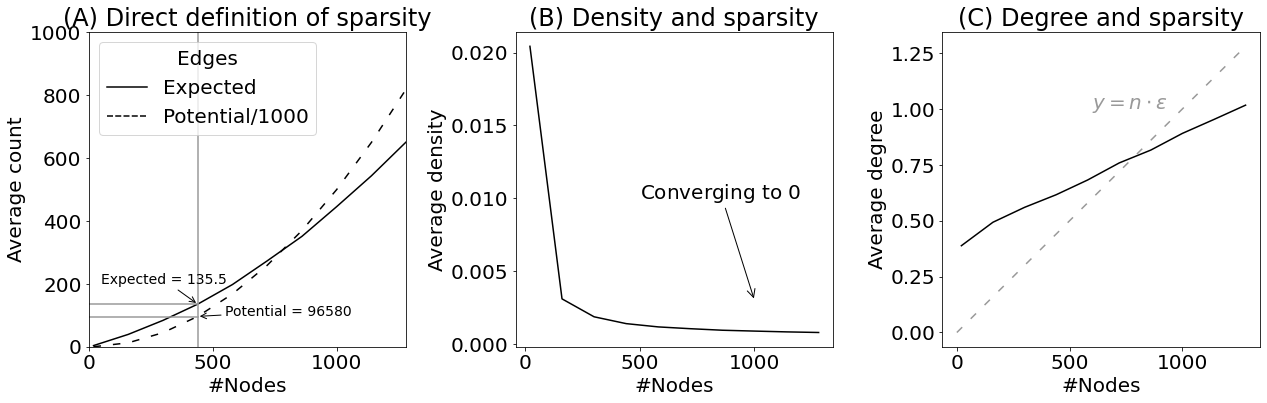

In [8]:
import seaborn as sns
import os
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

dash_patterns={"Expected": [], "Potential/1000": (5, 8)}
sns.lineplot(data=df_mean, x="#Nodes", y="Count", style="Edges", color="black", ax=axs[0])
axs[0].set_title("(A) Direct definition of sparsity")
axs[0].plot([0, 440], [int(df_wide[df_wide["#Nodes"] == 440]["Potential/1000"])]*2, color="#999999")
axs[0].plot([0, 440], [int(df_wide[df_wide["#Nodes"] == 440]["Expected"])]*2, color="#999999")
axs[0].axvline(x=440, color="#999999")
axs[0].set_xlim((0, 1280))
axs[0].set_ylim((0, 1000))
axs[0].set_ylabel("Average count")
axs[0].annotate("Potential = {:d}".format(int(1000*df_wide[df_wide["#Nodes"] == 440]["Potential/1000"])), xytext=(550, 100),
                xy=(440, df_wide[df_wide["#Nodes"] == 440]["Potential/1000"]), fontsize=14, arrowprops={"arrowstyle": "->"})
axs[0].annotate("Expected = {:.1f}".format(float(df_wide[df_wide["#Nodes"] == 440]["Expected"])), xytext=(50, 200),
                xy=(440, df_wide[df_wide["#Nodes"] == 440]["Expected"]), fontsize=14, arrowprops={"arrowstyle": "->"})

for line, category in zip(axs[0].lines, dash_patterns.keys()):
    if dash_patterns[category]:  # Check if there's a dash pattern for the category
        line.set_dashes(dash_patterns[category])
    else:
        line.set_linestyle('-')

sns.lineplot(data=df_wide, x="#Nodes", y="Density", color="black", ax=axs[1])
axs[1].set_title("(B) Density and sparsity")
axs[1].annotate("Converging to $0$", xy=(1000, .003), xytext=(500, .01), arrowprops={"arrowstyle": "->"})
axs[1].set_ylabel("Average density")

sns.lineplot(data=df_wide, x="#Nodes", y="Degree", color="black", ax=axs[2])
axs[2].set_title("(C) Degree and sparsity")
axs[2].plot([0, 1280], [0, 1280*.001], color="#999999", linestyle="--", dashes=(5, 8))
axs[2].set_ylabel("Average degree")
axs[2].annotate("$y = n \\cdot \\epsilon$", xy=(600, 1), color="#999999")
# axs[2].annotate("Average degree \nfalling relative line\n proportional to $n$", xy=(200, 1.0), xytext=(500, .01), arrowprops={"arrowstyle": "->"})

fig.tight_layout()

os.makedirs("Figures", exist_ok=True)
fname = "sparsity"
if mode != "png":
    os.makedirs(f"Figures/{mode:s}", exist_ok=True)
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

os.makedirs("Figures/png", exist_ok=True)
fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
np.random.seed(0)
K = 10; nk = 100
P, zs = academic_example(K, nk=nk, return_zs=True)
A = sample_edges(P)

print(f"# Non-zero entries: {A.sum().astype(int)}")  
# Non-zero entries: 5308

print(f"# Number of entries: {A.size}")  
# Number of entries: 1000000

In [ ]:
print(f"Size in KB: {A.nbytes/1000:.3f} KB")
# Size in KB: 8000.000 KB

B = A.astype(np.uint8)
print(f"Size in KB: {B.nbytes/1000:.3f} KB")
# Size in KB: 1000.000 KB

In [ ]:
import scipy.sparse as sparse

Btriu = sparse.triu(B)
print(f"Size in KB: {Btriu.data.size/1000:.3f} KB")
# Size in KB: 2.654 KB

In [ ]:
Btriu
# <1000x1000 sparse matrix of type '<class 'numpy.uint8'>'
#     with 2654 stored elements in COOrdinate format>

In [ ]:
from graspologic.utils import symmetrize

# cast the sparse matrix back to a dense matrix,
# and then triu symmetrize with graspologic
A_new = symmetrize(Btriu.todense(), method="triu")
np.array_equal(A_new, A)  # True

In [ ]:
import time
import scipy as sp

# a naive full svd on the dense matrix
timestart = time.time()
U, S, Vh = sp.linalg.svd(A)
Xhat = U[:, 0:10] @ np.diag(np.sqrt(S[0:10]))
timeend = time.time()
print(f"Naive approach: {timeend - timestart:3f} seconds")
# we get about 0.91 seconds

# a sparse svd on the sparse matrix
Acoo = sparse.coo_array(A)
timestart = time.time()
U, S, Vh = sp.sparse.linalg.svds(Acoo, k=10)
Xhat = U @ np.diag(np.sqrt(S))
timeend = time.time()
print(f"Sparse approach: {timeend-timestart:3f} seconds")
# we get about .03 seconds

In [ ]:
degrees = A.sum(axis=0)

In [ ]:
from graphbook_code import heatmap

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

heatmap(P, ax=axs[0], xtitle="Node", vmin=0, vmax=1, inner_hier_labels=zs)
heatmap(A.astype(int), ax=axs[1], xtitle="Node", inner_hier_labels=zs)
axs[0].set_title("(A) Probability matrix", pad=60)
axs[1].set_title("(B) Adjacency matrix", pad=60)
fig.tight_layout()

sns.histplot(degrees, ax=axs[2], color="black")
axs[2].set_xlabel("Node degree")
axs[2].set_title("(C) Degree histogram", pad=34)

fname = "eigenspoke_ex"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
from graspologic.utils import to_laplacian
from graspologic.plot import pairplot

# use sparse svd, so that we don't need to compute
# 1000 singular vectors and can just calculate the top 10
U, S, Vh = sp.sparse.linalg.svds(to_laplacian(A), k=10, random_state=0)
# plot the first 4
fig = pairplot(U[:,0:4], labels=zs, title="(A) Eigenspokes in the Laplacian", legend_name="Community")

fname = "eigenspokesa"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
U, S, Vh = sp.sparse.linalg.svds(A, k=10, random_state=0)
# plot the first 4
fig = pairplot(U[:,0:4], labels=zs, title="(B) Eigenspokes in the adjacency matrix", legend_name="Community")

fname = "eigenspokesb"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
print("# Expected edges: {:.2f}".format(np.triu(P).sum()))
# Expected edges: 2654.00
print("# True edges: {:d}".format(np.triu(A).sum().astype(int)))
# True edges: 2654
print("# Potential edges: {:d}".format(int(K*nk*(K*nk - 1)/2)))
# Potential edges: 499500